# DSH Dispatch Data Analysis
This notebook analyzes dispatch-related datasets from Meituan to understand courier wave patterns, order distributions, and dispatch efficiency.

## Datasets provided:
1. **courier_wave_info_meituan.csv** - Contains details about courier wave timings and assigned orders.
2. **dispatch_rider_meituan.csv** - Includes dispatch details for riders.
3. **dispatch_waybill_meituan.csv** - Contains dispatch waybill information.
4. **all_waybill_info_meituan_0322.csv** - Holds comprehensive waybill data.

We start by loading these datasets and performing an initial exploratory analysis.
        

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast

# Load datasets with error handling
def load_csv(filename, index_col=None):
    """Load a CSV file into a Pandas DataFrame."""
    try:
        return pd.read_csv(filename, index_col=index_col)
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        return None

# Load datasets
courier_wave = load_csv("courier_wave_info_meituan.csv")
dispatch_rider = load_csv("dispatch_rider_meituan.csv", index_col=0)
dispatch_waybill = load_csv("dispatch_waybill_meituan.csv", index_col=0)
all_orders = load_csv("all_waybill_info_meituan_0322.csv", index_col=0)

In [ ]:
# Function for dataset summary
def summarize_dataset(df, name):
    """Generate a summary of a DataFrame."""
    if df is not None:
        return {
            "Dataset": name,
            "Shape": df.shape,
            "Columns": df.columns.tolist(),
            "Missing Values": df.isnull().sum().to_dict(),
            "Data Types": df.dtypes.to_dict()
        }
    else:
        return {"Dataset": name, "Error": "Data not loaded"}

# Summarize datasets
datasets_info = [summarize_dataset(courier_wave, "Courier Wave"),
                 summarize_dataset(dispatch_rider, "Dispatch Rider"),
                 summarize_dataset(dispatch_waybill, "Dispatch Waybill"),
                 summarize_dataset(all_orders, "All Orders")]

# Display dataset summaries
import pprint
pprint.pprint(datasets_info)

[{'Columns': ['dt',
              'courier_id',
              'wave_id',
              'wave_start_time',
              'wave_end_time',
              'order_ids'],
  'Data Types': {'courier_id': dtype('int64'),
                 'dt': dtype('int64'),
                 'order_ids': dtype('O'),
                 'wave_end_time': dtype('int64'),
                 'wave_id': dtype('int64'),
                 'wave_start_time': dtype('int64')},
  'Dataset': 'Courier Wave',
  'Missing Values': {'courier_id': 0,
                     'dt': 0,
                     'order_ids': 0,
                     'wave_end_time': 0,
                     'wave_id': 0,
                     'wave_start_time': 0},
  'Shape': (206748, 6)},
 {'Columns': ['dt',
              'rider_lat',
              'rider_lng',
              'dispatch_time',
              'courier_waybills',
              'courier_id'],
  'Data Types': {'courier_id': dtype('int64'),
                 'courier_waybills': dtype('O'),
                 

In [ ]:
# Improved Data Visualization
def plot_missing_values(df, title):
    """Plot missing values in a dataset."""
    missing = df.isnull().sum()
    missing = missing[missing > 0]

    if not missing.empty:
        plt.figure(figsize=(8, 4))
        sns.barplot(x=missing.index, y=missing.values)
        plt.title(f"Missing Values in {title}")
        plt.xticks(rotation=45)
        plt.ylabel("Count")
        plt.show()
    else:
        print(f"No missing values in {title}")

# Check missing values for each dataset
plot_missing_values(courier_wave, "Courier Wave")
plot_missing_values(dispatch_rider, "Dispatch Rider")
plot_missing_values(dispatch_waybill, "Dispatch Waybill")
plot_missing_values(all_orders, "All Orders")

No missing values in Courier Wave
No missing values in Dispatch Rider
No missing values in Dispatch Waybill
No missing values in All Orders


#### Note: there are no clear missing values, but for any time column, if it is equal to 0, then this time cell is missing. 

## Data Cleaning

#### Convert `dt` from integer format (YYYYMMDD) to `datetime`

In [6]:
courier_wave["dt"] = pd.to_datetime(courier_wave["dt"], format="%Y%m%d")
dispatch_rider["dt"] = pd.to_datetime(dispatch_rider["dt"], format="%Y%m%d")
dispatch_waybill["dt"] = pd.to_datetime(dispatch_waybill["dt"], format="%Y%m%d")
all_orders["dt"] = pd.to_datetime(all_orders["dt"], format="%Y%m%d")

#### Convert `Unix` timestamps (`wave_start_time` & `wave_end_time`) to `datetime` format

In [7]:
courier_wave["wave_start_time"] = pd.to_datetime(courier_wave["wave_start_time"], unit="s")
courier_wave["wave_end_time"] = pd.to_datetime(courier_wave["wave_end_time"], unit="s")
dispatch_rider["dispatch_time"] = pd.to_datetime(dispatch_rider["dispatch_time"], unit="s")
dispatch_waybill["dispatch_time"] = pd.to_datetime(dispatch_waybill["dispatch_time"], unit="s")

all_order_time_cols = [
  "estimate_arrived_time",
  "platform_order_time",
  "estimate_meal_prepare_time",
  "order_push_time",
  "dispatch_time",
  "grab_time",
  "fetch_time",
  "arrive_time",
]

for col in all_order_time_cols:
    all_orders[col] = pd.to_datetime(all_orders[col], unit="s")
    all_orders.loc[all_orders[col] == pd.Timestamp(0), col] = pd.NaT

#### Convert `order_ids` from a string representation of a list to an actual list and add `wave_duration` and `num_orders` for the waves

In [8]:
courier_wave["order_ids"] = courier_wave["order_ids"].apply(lambda x: ast.literal_eval(x))

courier_wave["wave_duration"] = (courier_wave["wave_end_time"] - courier_wave["wave_start_time"]).dt.total_seconds()
courier_wave["num_orders"] = courier_wave["order_ids"].apply(len)

In [9]:
# Basic statistical summary
summary_stats = {
    "Total Records": len(courier_wave),
    "Number of Unique Couriers": courier_wave["courier_id"].nunique(),
    "Average Orders per Wave": courier_wave["num_orders"].mean(),
    "Average Wave Duration (seconds)": courier_wave["wave_duration"].mean(),
    "Median Wave Duration (seconds)": courier_wave["wave_duration"].median(),
    "Max Wave Duration (seconds)": courier_wave["wave_duration"].max(),
    "Min Wave Duration (seconds)": courier_wave["wave_duration"].min(),
}

summary_stats

{'Total Records': 206748,
 'Number of Unique Couriers': 4901,
 'Average Orders per Wave': np.float64(2.7499419583260782),
 'Average Wave Duration (seconds)': np.float64(2131.5054220597053),
 'Median Wave Duration (seconds)': np.float64(1685.0),
 'Max Wave Duration (seconds)': np.float64(42742.0),
 'Min Wave Duration (seconds)': np.float64(75.0)}

### **Initial EDA Insights from `courier_wave_info_meituan.csv`**
- **Total Records:** 206,748 waves.
- **Number of Unique Couriers:** 4,901 couriers.
- **Average Orders per Wave:** ~2.75 orders per wave.
- **Wave Duration:**
  - **Average:** ~2,131 seconds (~35.5 minutes).
  - **Median:** ~1,685 seconds (~28 minutes).
  - **Max:** 42,742 seconds (~11.9 hours)—possible outlier.
  - **Min:** 75 seconds (~1.25 minutes).

**Observations:**
- The **average number of orders per wave** is **~2.75**, which indicates that couriers handle **multiple orders per wave**.
- The **median wave duration** is **~1,685 seconds (~28 minutes)**, indicating a normal wave cycle.
- The **maximum duration** **~11.9 hours**, suggest **some waves take significantly longer** and this need investigation.
- The **minimum wave duration** is **75 seconds**, which may indicate quick deliveries or incorrect data.


#### **The next step is to fix the mismatch in wave start time as mentioned in the description file.**

In [10]:
all_orders.head()

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,...,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time
0,2022-10-17,0,0,0,0,0,1,2022-10-16 16:32:58,0,0,...,45852786,0,0,2022-10-16 16:04:18,NaT,NaT,NaT,2022-10-16 16:12:59,2022-10-16 16:00:00,2022-10-16 15:59:56
1,2022-10-17,1,1,1,1,1,1,2022-10-16 16:31:04,0,1,...,45898250,174530062,45906005,2022-10-16 16:12:14,2022-10-16 16:12:17,2022-10-16 16:22:24,2022-10-16 16:29:58,2022-10-16 16:14:05,2022-10-16 16:00:06,2022-10-16 15:59:55
2,2022-10-17,2,2,2,2,1,0,2022-10-16 16:58:24,0,2,...,45891243,174548244,45870923,2022-10-16 16:24:44,2022-10-16 16:25:01,2022-10-16 16:39:06,2022-10-16 16:56:24,2022-10-16 16:33:27,2022-10-16 16:18:27,2022-10-16 16:18:17
3,2022-10-17,3,3,3,0,1,0,2022-10-16 16:57:12,0,3,...,45886787,174560199,45867948,2022-10-16 16:23:14,2022-10-16 16:23:17,2022-10-16 16:30:30,2022-10-16 17:03:42,2022-10-16 16:27:14,2022-10-16 16:22:49,2022-10-16 16:17:08
4,2022-10-17,4,4,4,0,1,0,2022-10-16 16:48:14,0,3,...,45867411,174554896,45865167,2022-10-16 16:23:14,2022-10-16 16:23:33,2022-10-16 16:28:30,2022-10-16 16:37:42,2022-10-16 16:28:14,2022-10-16 16:22:53,2022-10-16 16:18:12


In [11]:
courier_wave.head()

,dt,courier_id,wave_id,wave_start_time,wave_end_time,order_ids,wave_duration,num_orders
0,2022-10-17,0,1,2022-10-17 13:59:59,2022-10-17 14:20:27,[171478],1228.0,1
1,2022-10-17,0,2,2022-10-17 15:07:53,2022-10-17 15:33:02,[116902],1509.0,1
2,2022-10-17,1,1,2022-10-16 16:12:17,2022-10-16 16:29:58,[1],1061.0,1
3,2022-10-17,1,2,2022-10-17 03:11:57,2022-10-17 04:07:23,"[264834, 107524, 334962, 125682, 493460]",3326.0,5
4,2022-10-17,2,1,2022-10-16 16:37:57,2022-10-16 17:05:55,"[264776, 2, 398099, 389973]",1678.0,4


#### Fix `wave_start_time` in courier waver based on the `grab_time` in all orders

In [12]:
courier_wave_exploded = courier_wave.explode("order_ids")
courier_wave_exploded["order_ids"] = courier_wave_exploded["order_ids"].astype(int)  # Convert to int for merge

# Filter all_orders to only include orders that were grabbed by a courier
all_orders_filtered = all_orders[all_orders["is_courier_grabbed"] == 1].copy()

# Merge with all_orders to get the grab_time
merged = courier_wave_exploded.merge(
    all_orders_filtered[["order_id", "grab_time"]],
    left_on="order_ids",
    right_on="order_id",
    how="left",
)

# Group by original wave_id and find the minimum grab_time
corrected_times = (merged.groupby(["dt", "courier_id", "wave_id"])["grab_time"].min().reset_index())

# Merge corrected times back to the original dataframe
courier_wave = courier_wave.merge(corrected_times, on=["dt", "courier_id", "wave_id"])

# Update wave_start_time where necessary
mask = courier_wave["wave_start_time"] != courier_wave["grab_time"]
courier_wave.loc[mask, "wave_start_time"] = courier_wave["grab_time"]

# Drop the helper column
courier_wave.drop(columns=["grab_time"], inplace=True)

# Summary of corrections
print(f"Updated {mask.sum()} wave_start_time entries.")

Updated 65904 wave_start_time entries.


In [13]:
courier_wave.head()

,dt,courier_id,wave_id,wave_start_time,wave_end_time,order_ids,wave_duration,num_orders
0,2022-10-17,0,1,2022-10-17 13:59:59,2022-10-17 14:20:27,[171478],1228.0,1
1,2022-10-17,0,2,2022-10-17 15:07:53,2022-10-17 15:33:02,[116902],1509.0,1
2,2022-10-17,1,1,2022-10-16 16:12:17,2022-10-16 16:29:58,[1],1061.0,1
3,2022-10-17,1,2,2022-10-17 03:11:53,2022-10-17 04:07:23,"[264834, 107524, 334962, 125682, 493460]",3326.0,5
4,2022-10-17,2,1,2022-10-16 16:20:49,2022-10-16 17:05:55,"[264776, 2, 398099, 389973]",1678.0,4


In [14]:
courier_wave["wave_duration"] = (courier_wave["wave_end_time"] - courier_wave["wave_start_time"]).dt.total_seconds()
courier_wave["num_orders"] = courier_wave["order_ids"].apply(len)

# Basic statistical summary
summary_stats = {
    "Total Records": len(courier_wave),
    "Number of Unique Couriers": courier_wave["courier_id"].nunique(),
    "Average Orders per Wave": courier_wave["num_orders"].mean(),
    "Average Wave Duration (seconds)": courier_wave["wave_duration"].mean(),
    "Median Wave Duration (seconds)": courier_wave["wave_duration"].median(),
    "Max Wave Duration (seconds)": courier_wave["wave_duration"].max(),
    "Min Wave Duration (seconds)": courier_wave["wave_duration"].min(),
}

summary_stats

{'Total Records': 206748,
 'Number of Unique Couriers': 4901,
 'Average Orders per Wave': np.float64(2.7499419583260782),
 'Average Wave Duration (seconds)': np.float64(2230.9886576895547),
 'Median Wave Duration (seconds)': np.float64(1795.0),
 'Max Wave Duration (seconds)': np.float64(42742.0),
 'Min Wave Duration (seconds)': np.float64(75.0)}

### Statistics of `courier_wave_info_meituan.csv` after fixing wave time start

As noted in the description file, some entries in wave start time aren't correct due to indexing, and here are the statistics after solving it, and we can see that we still have the problem of the long duration waves.

- **Total Records:** 206,748 waves.
- **Number of Unique Couriers:** 4,901 couriers.
- **Average Orders per Wave:** ~2.75 orders per wave.
- **Wave Duration:**
  - **Average:** ~2,230 seconds (~37.2 minutes).
  - **Median:** ~1,795 seconds (~29.9 minutes).
  - **Max:** 42,742 seconds (~11.9 hours) — possible outlier.
  - **Min:** 75 seconds (~1.25 minutes).

**Next Steps:**
- Investigate **long-duration waves** for potential **outliers**.
- Analyze **distribution of wave durations** to detect any anomalies.
- Identify **factors affecting wave duration**, such as **order quantity per wave or time of day**.


### We first plot the distribution of the long duration waves, to understand the frequency of the outlier points. 

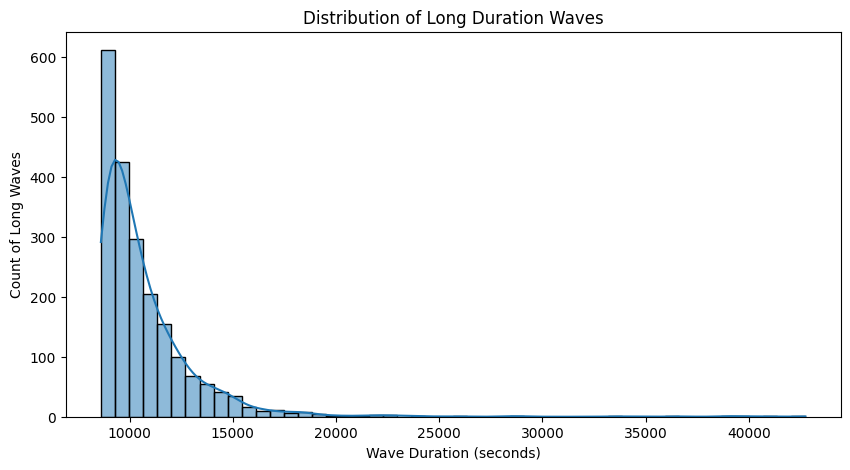

{'Total Long Duration Waves': 2068,
 'Percentage of Total Waves': 1.000251513920328,
 'Average Long Wave Duration (seconds)': np.float64(10715.18085106383),
 'Median Long Wave Duration (seconds)': np.float64(9965.5),
 'Max Long Wave Duration (seconds)': np.float64(42742.0),
 'Min Long Wave Duration (seconds)': np.float64(8605.0)}

In [54]:
# Identify long-duration waves (e.g., top 1% longest durations)
threshold = courier_wave["wave_duration"].quantile(0.99)  # 99th percentile threshold
long_waves = courier_wave[courier_wave["wave_duration"] >= threshold]

# Summary statistics of long-duration waves
long_wave_stats = {
    "Total Long Duration Waves": len(long_waves),
    "Percentage of Total Waves": len(long_waves) / len(courier_wave) * 100,
    "Average Long Wave Duration (seconds)": long_waves["wave_duration"].mean(),
    "Median Long Wave Duration (seconds)": long_waves["wave_duration"].median(),
    "Max Long Wave Duration (seconds)": long_waves["wave_duration"].max(),
    "Min Long Wave Duration (seconds)": long_waves["wave_duration"].min(),
}

# Visualizing long-duration wave distribution
plt.figure(figsize=(10, 5))
sns.histplot(long_waves["wave_duration"], bins=50, kde=True)
plt.xlabel("Wave Duration (seconds)")
plt.ylabel("Count of Long Waves")
plt.title("Distribution of Long Duration Waves")
plt.show()

long_wave_stats

Now, it seems that the outliers are points over `20,000` seconds (~5.5 hours)

In [16]:
# Filter waves with duration greater than 20,000 seconds (~5.5 hours)
long_duration_waves = courier_wave[courier_wave["wave_duration"] > 20000]
long_duration_waves

,dt,courier_id,wave_id,wave_start_time,wave_end_time,order_ids,wave_duration,num_orders
4347,2022-10-17,509,7,2022-10-17 08:57:34,2022-10-17 15:03:50,"[13187, 545668, 506635, 80139, 287889, 427797,...",21976.0,27
15112,2022-10-17,2136,3,2022-10-17 04:18:58,2022-10-17 10:22:25,"[186128, 32287]",21807.0,2
24251,2022-10-17,4223,1,2022-10-16 23:57:14,2022-10-17 10:06:11,[365532],36537.0,1
24448,2022-10-17,4317,2,2022-10-17 04:13:46,2022-10-17 13:33:30,"[403712, 457089, 287750, 29191, 368392, 498698...",33584.0,59
25152,2022-10-18,7,1,2022-10-17 16:28:03,2022-10-17 22:37:10,"[171494, 349068, 321516, 374068, 19704]",22147.0,5
27413,2022-10-18,275,1,2022-10-17 22:13:13,2022-10-18 04:04:21,"[126050, 250857, 514601, 457138, 384788, 35701...",21068.0,8
43008,2022-10-18,2496,3,2022-10-18 07:23:57,2022-10-18 13:58:36,"[111233, 327172, 165768, 108040, 251024, 34651...",23679.0,29
49990,2022-10-18,4176,1,2022-10-18 00:35:49,2022-10-18 06:29:28,"[262451, 58021]",21219.0,2
53533,2022-10-19,322,4,2022-10-19 06:18:25,2022-10-19 12:39:19,"[488968, 291209, 49162, 129554, 302483, 556574...",22854.0,26
60185,2022-10-19,1129,2,2022-10-18 16:35:19,2022-10-19 04:27:41,"[207334, 352235, 491404, 105301, 26520]",42742.0,5


Now, if we take a look at the order at row `24251` from the all orders data, we get the following:

In [17]:
# Retrieve the row corresponding to the given order_id
order_id_to_find = 365532  
order_row = all_orders[all_orders["order_id"] == order_id_to_find]
order_row

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,...,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time
402819,2022-10-17,365532,402819,4223,5,1,0,2022-10-17 10:20:00,1,7,...,45929863,174560618,45888719,2022-10-16 23:51:42,2022-10-16 23:57:14,2022-10-17 09:21:45,2022-10-17 10:06:11,NaT,2022-10-16 23:51:42,2022-10-16 23:51:06


### The next step is to verify this assumption by 

This is an example of an order that was requested at night and needed to be fetched in the morning, hence the long delivery time.
And it seems that the issue is that the order was prebooked `is_prebook = 1` and the `estimate_meal_prepare_time` is missing

/var/folders/l3/773m_fwj2gx_g_w1fggfcdgw0000gn/T/ipykernel_16762/3319990499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prebooked_orders["time_gap"] = (prebooked_orders["fetch_time"] - prebooked_orders["grab_time"]).dt.total_seconds()


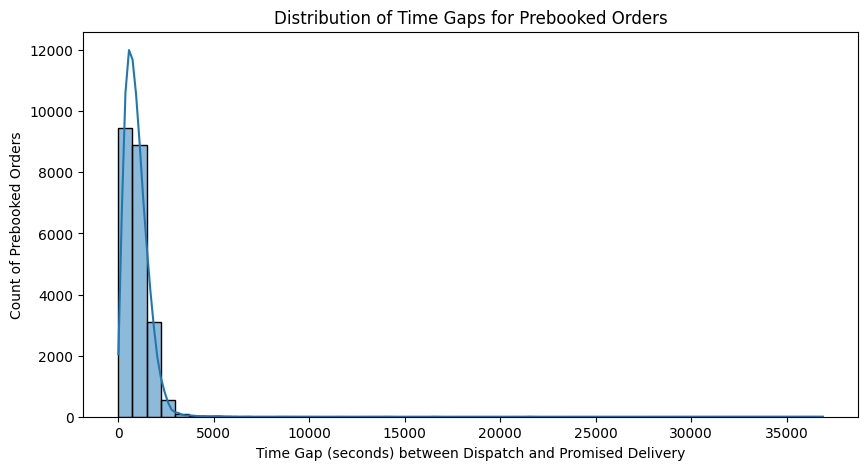

count    22181.000000
mean       969.386953
std        873.323332
min          3.000000
25%        507.000000
50%        847.000000
75%       1281.000000
max      36897.000000
Name: time_gap, dtype: float64

In [18]:
# Filter for prebooked orders
prebooked_orders = all_orders[all_orders["is_prebook"] == 1]

# Calculate time difference between grab time and fetch time
prebooked_orders["time_gap"] = (prebooked_orders["fetch_time"] - prebooked_orders["grab_time"]).dt.total_seconds()

# Summary statistics
summary_stats = prebooked_orders["time_gap"].describe()

# Plot distribution of time gaps
plt.figure(figsize=(10, 5))
sns.histplot(prebooked_orders["time_gap"], bins=50, kde=True)
plt.xlabel("Time Gap (seconds) between Dispatch and Promised Delivery")
plt.ylabel("Count of Prebooked Orders")
plt.title("Distribution of Time Gaps for Prebooked Orders")
plt.show()

summary_stats


/var/folders/l3/773m_fwj2gx_g_w1fggfcdgw0000gn/T/ipykernel_16762/3499488659.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_prebooked_orders["time_gap"] = (


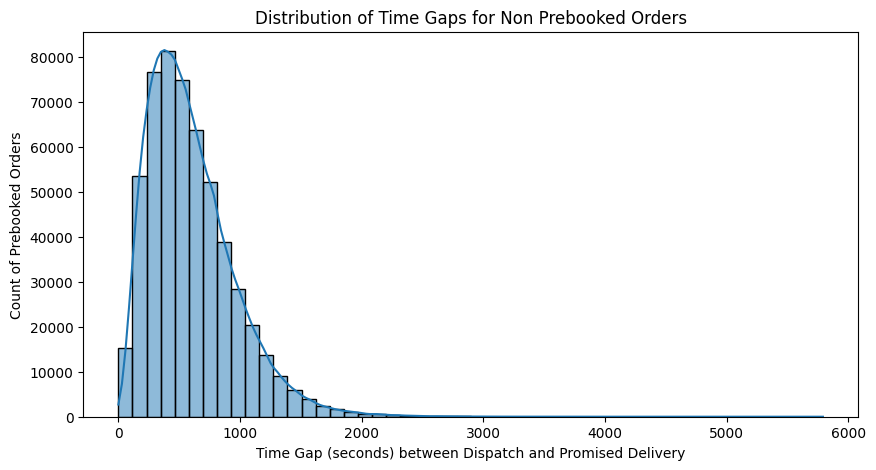

count    546365.000000
mean        600.941025
std         359.990675
min           2.000000
25%         337.000000
50%         535.000000
75%         792.000000
max        5790.000000
Name: time_gap, dtype: float64

In [19]:
# Filter for prebooked orders
non_prebooked_orders = all_orders[all_orders["is_prebook"] == 0]

# Calculate time difference between grab time and fetch time
non_prebooked_orders["time_gap"] = (
    non_prebooked_orders["fetch_time"] - non_prebooked_orders["grab_time"]
).dt.total_seconds()

# Summary statistics
summary_stats = non_prebooked_orders["time_gap"].describe()

# Plot distribution of time gaps
plt.figure(figsize=(10, 5))
sns.histplot(non_prebooked_orders["time_gap"], bins=50, kde=True)
plt.xlabel("Time Gap (seconds) between Dispatch and Promised Delivery")
plt.ylabel("Count of Prebooked Orders")
plt.title("Distribution of Time Gaps for Non Prebooked Orders")
plt.show()

summary_stats


### **Comparison of Time Gap Between Fetched and Grap Times for Prebooked vs. Non-Prebooked Orders**

#### **Summary Statistics**

| Metric                     | **Prebooked Orders** (24,109) | **Non-Prebooked Orders** (630,234) |
|----------------------------|--------------------------|------------------------------|
| **Mean Time Gap**          | **891.86 sec** (~14.9 min) | **520.97 sec** (~8.7 min) |
| **Standard Deviation**     | 877.98 sec (~14.6 min) | 392.44 sec (~6.5 min) |
| **Minimum Time Gap**       | 0 sec | 0 sec |
| **25th Percentile (Q1)**   | 418 sec (~7 min) | 241 sec (~4 min) |
| **Median (Q2, 50%)**       | 786 sec (~13 min) | 472 sec (~7.9 min) |
| **75th Percentile (Q3)**   | 1,235 sec (~20.5 min) | 745 sec (~12.4 min) |
| **Maximum Time Gap**       | **36,897 sec** (~10.25 hrs) 🚨 | **5,790 sec** (~1.6 hrs) |


### **Conclusion**
**Prebooked orders are assigned much earlier than non-prebooked orders.**

Actually they get assigned when you are ordered not when they are expected to be fulfilled, which is an issue in the system and the issue is related to having `estimated_meal_prepare_time` missing.  

But since the number of orders that are prebooked with with high gap is small. 


### Orders per Dispatch Cycle (Batch Size)

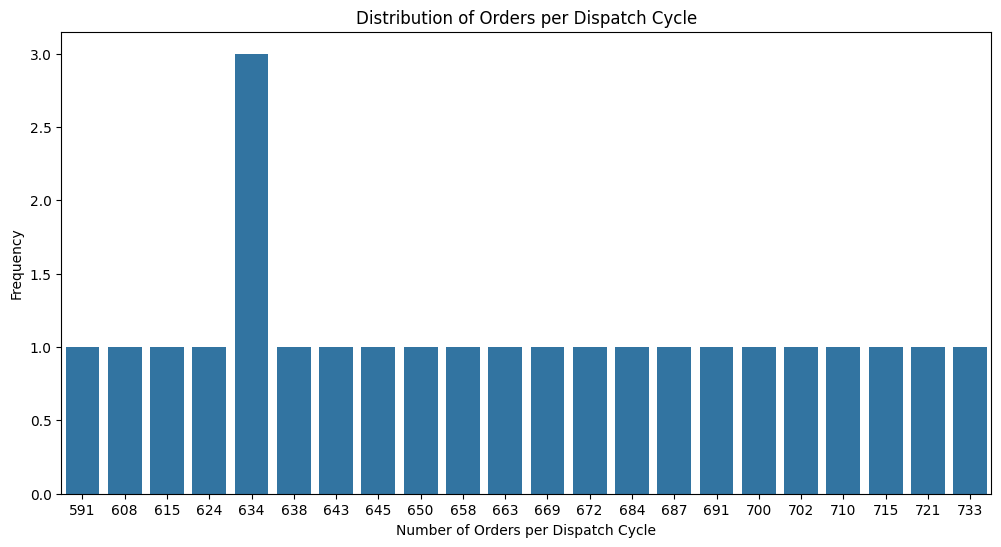

In [31]:
# Count how many orders are assigned in each dispatch cycle
batch_size = dispatch_waybill.groupby("dispatch_time")["order_id"].count()

plt.figure(figsize=(12, 6))
sns.barplot(x=batch_size.value_counts().index, y=batch_size.value_counts().values)
plt.xlabel("Number of Orders per Dispatch Cycle")
plt.ylabel("Frequency")
plt.title("Distribution of Orders per Dispatch Cycle")
plt.show()

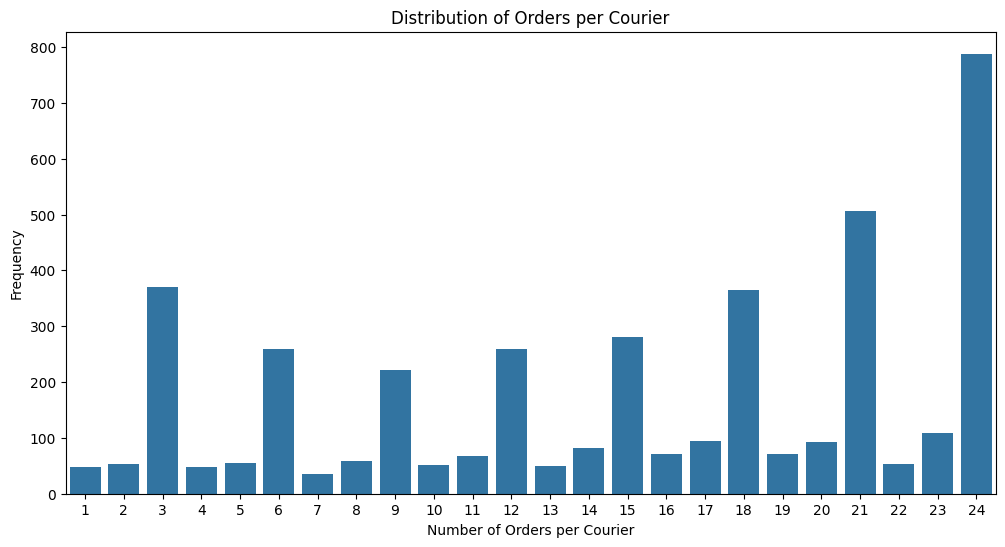

In [30]:
# Count number of orders assigned per courier
courier_workload = dispatch_rider.groupby("courier_id")["courier_waybills"].count()

# Plot distribution of orders per courier
plt.figure(figsize=(12, 6))
sns.barplot(x=courier_workload.value_counts().index, y=courier_workload.value_counts().values)
plt.xlabel("Number of Orders per Courier")
plt.ylabel("Frequency")
plt.title("Distribution of Orders per Courier")
plt.show()

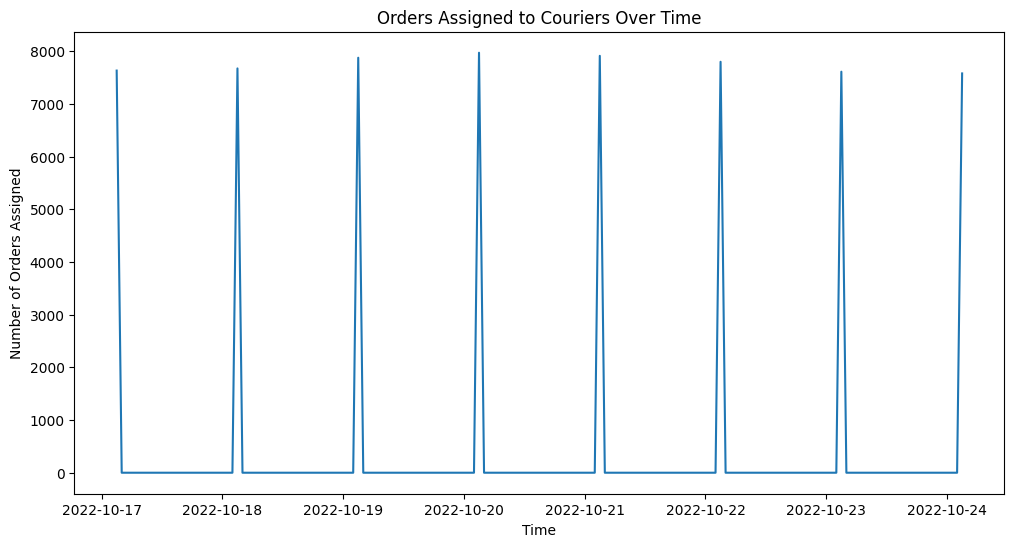

In [ ]:
# Count number of orders assigned per hour 
workload_time = (
    dispatch_rider.set_index("dispatch_time").resample("h")["courier_id"].count()
)

# Plot workload trends
plt.figure(figsize=(12, 6))
sns.lineplot(x=workload_time.index, y=workload_time.values)
plt.xlabel("Time")
plt.ylabel("Number of Orders Assigned")
plt.title("Orders Assigned to Couriers Over Time")
plt.show()

In [43]:
# Count unique dispatch times per day
dispatch_time_counts = dispatch_rider.groupby("dt")["dispatch_time"].unique()

# Display results
dispatch_time_counts["2022-10-17"]


<DatetimeArray>
['2022-10-17 03:25:14', '2022-10-17 03:27:14', '2022-10-17 03:30:14']
Length: 3, dtype: datetime64[ns]

#### Dispatches Always Happening at Fixed Times (03:25, 03:27, 03:30)

In `dispatch_rider_meituan.csv`, the `dispatch_time` is always over those 3 mins (03:25, 03:27, 03:30), and it not consistent with `all_waybill_info_meituan_0322.csv`.


In [49]:
# Orders with the longest wait time before assignment
order_dispatch.sort_values("time_to_dispatch", ascending=False).head(20)


632651